In [2]:
# === Core Python & I/O ===
import os
import time
import math
import json
from pathlib import Path
from tqdm import tqdm
import timm
import torch.nn as nn
# === Torch and related ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image

# === Metrics & Utilities ===
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === Constants ===
CLASS_NAMES = ["cider", "wheat", "lager", "ipa", "stout", "not_beer"]


In [3]:
!pip install timm

# Full model training - EffNet

In [ ]:
def model_fn(dropout):
    model = timm.create_model("efficientnet_b0", pretrained=True)
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.classifier.in_features, 6)
    )
    return model

In [ ]:
from torchvision import transforms

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.05),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
from pathlib import Path
DATA_DIR = Path("sample_data/photos")  # <-- CHANGE THIS to your actual path
N_AUG_PER_IMAGE = 1                 # how many augmented versions per original
IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"]

# === Define augmentations ===
augment = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

# === Go through each class directory ===
for class_dir in DATA_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    # Create the "augmented/" subfolder inside each class dir
    aug_dir = class_dir

    for img_path in tqdm(list(class_dir.glob("*")), desc=f"Augmenting {class_dir.name}"):
        if not img_path.is_file() or img_path.suffix.lower() not in IMAGE_EXTENSIONS:
            continue
        if "augmented" in str(img_path):  # skip already-augmented files
            continue

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Skipping {img_path.name}: {e}")
            continue

        for i in range(N_AUG_PER_IMAGE):
            aug_img = augment(img)
            new_name = f"{img_path.stem}_aug{i}{img_path.suffix}"
            aug_img.save(aug_dir / new_name)

Augmenting ipa: 100%|██████████| 494/494 [00:14<00:00, 33.62it/s]


In [ ]:
!rm -rf /content/sample_data/photos/.ipynb_checkpoints

dataset = datasets.ImageFolder(root="/content/sample_data/photos", transform=transform)

In [ ]:
train_ratio, val_ratio = 0.8, 0.1
train_size = int(train_ratio * len(dataset))
val_size   = int(val_ratio * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# --- Assign transforms ---
train_dataset.dataset.transform = train_transform  # train set gets aug
val_dataset.dataset.transform   = eval_transform   # val set = eval tfms
test_dataset.dataset.transform  = eval_transform   # test set = eval tfms

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(val_size)

686


In [ ]:
def train_and_evaluate(lr, weight_decay, dropout, patience,
                       max_epochs=25, device="cuda" if torch.cuda.is_available() else "cpu"):

    model = model_fn(dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Step on validation accuracy (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=False
    )

    best_acc = 0.0
    best_state = None
    epochs_without_improve = 0

    print(f"\n=== Training with lr={lr:.6f}, wd={weight_decay:.6f}, dr={dropout:.3f}, patience={patience} ===")
    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        total_train, correct_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = logits.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # ---- Validate ----
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = correct_val / total_val if total_val > 0 else 0.0

        # LR schedule on metric
        scheduler.step(val_acc)

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            epochs_without_improve = 0
            improved = "✅"
        else:
            epochs_without_improve += 1
            improved = "—"

        # Current LR
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        print(f"Epoch [{epoch:02d}/{max_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | Best: {best_acc:.4f} {improved} | "
              f"LR: {current_lr:.6f}")

        if epochs_without_improve >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}")
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return best_acc


In [ ]:
lr_range = (0.001, 0.0001)
wd_range = (1e-6, 1e-3)
dropout_range = (0.1, 0.6)
patience_range = (2, 4)

num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate(**params, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000116, wd=0.000004, dr=0.194, patience=3 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [01/5] | Train Loss: 1.2798 | Train Acc: 0.5432 | Val Acc: 0.6924 | Best: 0.6924 ✅ | LR: 0.000116
Epoch [02/5] | Train Loss: 0.6716 | Train Acc: 0.7722 | Val Acc: 0.7566 | Best: 0.7566 ✅ | LR: 0.000116
Epoch [03/5] | Train Loss: 0.4021 | Train Acc: 0.8652 | Val Acc: 0.7959 | Best: 0.7959 ✅ | LR: 0.000116
Epoch [04/5] | Train Loss: 0.1933 | Train Acc: 0.9446 | Val Acc: 0.7974 | Best: 0.7974 ✅ | LR: 0.000116
Epoch [05/5] | Train Loss: 0.0874 | Train Acc: 0.9770 | Val Acc: 0.8003 | Best: 0.8003 ✅ | LR: 0.000116
[1/10] lr=0.000116, wd=0.000004, dr=0.194, pt=3 -> val acc=0.8003

=== Training with lr=0.000854, wd=0.000188, dr=0.451, patience=3 ===
Epoch [01/5] | Train Loss: 0.9218 | Train Acc: 0.6822 | Val Acc: 0.7507 | Best: 0.7507 ✅ | LR: 0.000854
Epoch [02/5] | Train Loss: 0.4650 | Train Acc: 0.8400 | Val Acc: 0.8076 | Best: 0.8076 ✅ | LR: 0.000854
Epoch [03/5] | Train Loss: 0.2625 | Train Acc: 0.9105 | Val Acc: 0.7857 | Best: 0.8076 — | LR: 0.000854
Epoch [04/5] | Train Loss: 0.196

Epoch 1/20 | Train Loss: 1.0310 | Validation Accuracy: 75.22%
Epoch 2/20 | Train Loss: 0.4499 | Validation Accuracy: 81.34%
Epoch 3/20 | Train Loss: 0.1536 | Validation Accuracy: 82.36%
Epoch 4/20 | Train Loss: 0.0716 | Validation Accuracy: 84.84%
Epoch 5/20 | Train Loss: 0.0456 | Validation Accuracy: 82.80%
Epoch 6/20 | Train Loss: 0.0565 | Validation Accuracy: 82.07%
Epoch 7/20 | Train Loss: 0.0447 | Validation Accuracy: 82.65%
Epoch 8/20 | Train Loss: 0.0423 | Validation Accuracy: 83.53%
Epoch 9/20 | Train Loss: 0.0153 | Validation Accuracy: 85.28%
Epoch 10/20 | Train Loss: 0.0062 | Validation Accuracy: 84.55%
Epoch 11/20 | Train Loss: 0.0043 | Validation Accuracy: 84.99%
Epoch 12/20 | Train Loss: 0.0025 | Validation Accuracy: 85.28%
Epoch 13/20 | Train Loss: 0.0028 | Validation Accuracy: 86.01%
Epoch 14/20 | Train Loss: 0.0021 | Validation Accuracy: 86.44%
Epoch 15/20 | Train Loss: 0.0021 | Validation Accuracy: 86.88%
Epoch 16/20 | Train Loss: 0.0011 | Validation Accuracy: 86.88%
E

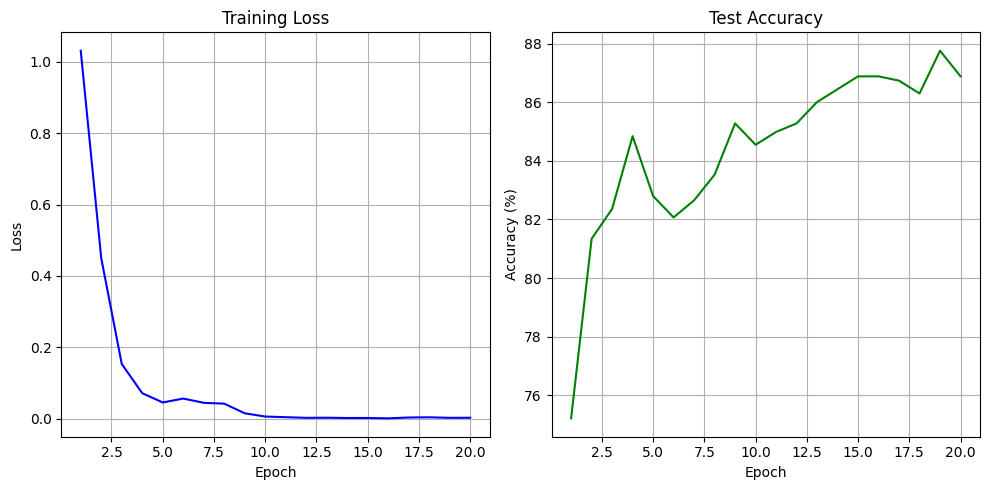

In [ ]:
best_lr, best_wd, best_dropout, best_patience = 0.000299, 0.000002,0.188, 3 #From earlier because we dont want to run the validaion cell a lot of time

model = model_fn(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 20
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
torch.save(best_model_state, "best_model_eff_fulltrain.pth")


In [ ]:
NOTE: test accuracy is a typo its validation acc, im writing it here because we caugh it too late to re run everything

# Feauture extraction - EffNet

In [12]:
def model_fn_feature_extract(dropout=0.4, num_classes=6):
    model = timm.create_model("efficientnet_b0", pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.classifier.in_features, num_classes)
    )
    for param in model.classifier.parameters():
        param.requires_grad = True  # only train classifier
    return model

In [13]:
def train_and_evaluate_on_feature_extract(
    lr, weight_decay, dropout, patience,
    model_function=model_fn_feature_extract,  # <-- function name, not function call!
    max_epochs=25,
    device="cuda" if torch.cuda.is_available() else "cpu"
):

    model = model_function(dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Step on validation accuracy (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=False
    )

    best_acc = 0.0
    best_state = None
    epochs_without_improve = 0

    print(f"\n=== Training with lr={lr:.6f}, wd={weight_decay:.6f}, dr={dropout:.3f}, patience={patience} ===")
    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        total_train, correct_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = logits.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # ---- Validate ----
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = correct_val / total_val if total_val > 0 else 0.0

        # LR schedule on metric
        scheduler.step(val_acc)

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            epochs_without_improve = 0
            improved = "✅"
        else:
            epochs_without_improve += 1
            improved = "—"

        # Current LR
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        print(f"Epoch [{epoch:02d}/{max_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | Best: {best_acc:.4f} {improved} | "
              f"LR: {current_lr:.6f}")

        if epochs_without_improve >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}")
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return best_acc


In [ ]:
num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate_on_feature_extract(**params,model_function=model_fn_feature_extract, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000822, wd=0.000638, dr=0.109, patience=4 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [01/5] | Train Loss: 1.4570 | Train Acc: 0.4827 | Val Acc: 0.5612 | Best: 0.5612 ✅ | LR: 0.000822
Epoch [02/5] | Train Loss: 1.1490 | Train Acc: 0.6112 | Val Acc: 0.6093 | Best: 0.6093 ✅ | LR: 0.000822
Epoch [03/5] | Train Loss: 1.0447 | Train Acc: 0.6398 | Val Acc: 0.6181 | Best: 0.6181 ✅ | LR: 0.000822
Epoch [04/5] | Train Loss: 0.9842 | Train Acc: 0.6665 | Val Acc: 0.6210 | Best: 0.6210 ✅ | LR: 0.000822
Epoch [05/5] | Train Loss: 0.9461 | Train Acc: 0.6729 | Val Acc: 0.6297 | Best: 0.6297 ✅ | LR: 0.000822
[1/10] lr=0.000822, wd=0.000638, dr=0.109, pt=4 -> val acc=0.6297

=== Training with lr=0.000262, wd=0.000828, dr=0.415, patience=4 ===
Epoch [01/5] | Train Loss: 1.6865 | Train Acc: 0.3265 | Val Acc: 0.5029 | Best: 0.5029 ✅ | LR: 0.000262
Epoch [02/5] | Train Loss: 1.4750 | Train Acc: 0.5026 | Val Acc: 0.5656 | Best: 0.5656 ✅ | LR: 0.000262
Epoch [03/5] | Train Loss: 1.3437 | Train Acc: 0.5547 | Val Acc: 0.5773 | Best: 0.5773 ✅ | LR: 0.000262
Epoch [04/5] | Train Loss: 1.263

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 1.4680 | Validation Accuracy: 56.56%
Epoch 2/20 | Train Loss: 1.1628 | Validation Accuracy: 60.50%
Epoch 3/20 | Train Loss: 1.0561 | Validation Accuracy: 62.24%
Epoch 4/20 | Train Loss: 0.9989 | Validation Accuracy: 63.56%
Epoch 5/20 | Train Loss: 0.9607 | Validation Accuracy: 64.58%
Epoch 6/20 | Train Loss: 0.9297 | Validation Accuracy: 64.29%
Epoch 7/20 | Train Loss: 0.9033 | Validation Accuracy: 63.99%
Epoch 8/20 | Train Loss: 0.8860 | Validation Accuracy: 64.43%
Epoch 9/20 | Train Loss: 0.8821 | Validation Accuracy: 64.87%
Epoch 10/20 | Train Loss: 0.8677 | Validation Accuracy: 63.99%
Epoch 11/20 | Train Loss: 0.8743 | Validation Accuracy: 64.87%
Epoch 12/20 | Train Loss: 0.8641 | Validation Accuracy: 64.43%
Epoch 13/20 | Train Loss: 0.8636 | Validation Accuracy: 64.43%
Epoch 14/20 | Train Loss: 0.8661 | Validation Accuracy: 64.29%
Epoch 15/20 | Train Loss: 0.8700 | Validation Accuracy: 64.43%
Epoch 16/20 | Train Loss: 0.8621 | Validation Accuracy: 64.14%
E

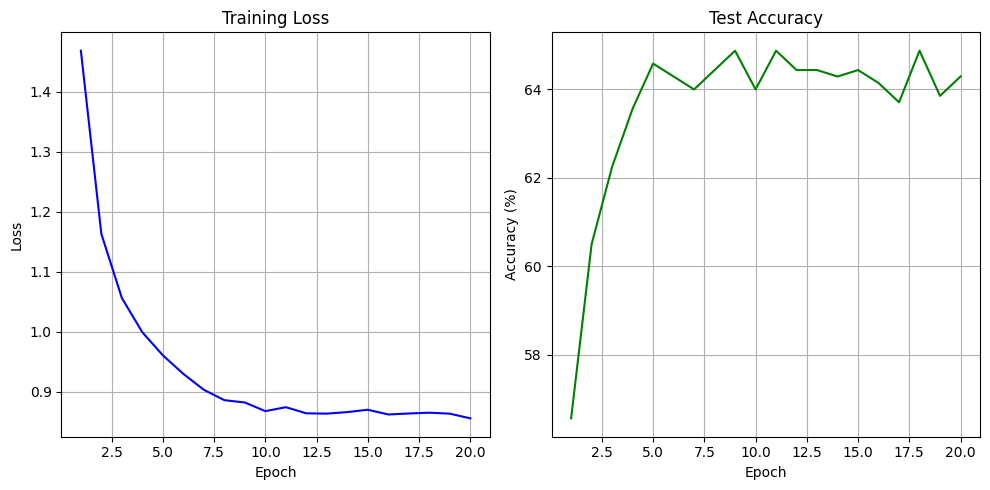

In [22]:
best_lr, best_wd, best_dropout, best_patience = 0.000822, 0.000638,0.109,0.6297

model = model_fn_feature_extract(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 20
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
torch.save(best_model_state, "best_model_eff_freezeout.pth")


In [ ]:
NOTE: test accuracy is a TYPO its validation acc, im writing it here because we noticed it too late to re run everything. 

# Partial model training - EffNet

In [23]:
def model_fn_partial(dropout=0.4, num_classes=6):
    model = timm.create_model("efficientnet_b0", pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # freeze everything first
    # Unfreeze last two blocks and classifier
    for name, param in model.named_parameters():
        if "blocks.5" in name or "blocks.6" in name or "classifier" in name:
            param.requires_grad = True
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.classifier.in_features, num_classes)
    )
    return model


In [ ]:
num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate_on_feature_extract(**params,model_function=model_fn_partial, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000185, wd=0.000040, dr=0.155, patience=2 ===
Epoch [01/5] | Train Loss: 1.2699 | Train Acc: 0.5485 | Val Acc: 0.6880 | Best: 0.6880 ✅ | LR: 0.000185
Epoch [02/5] | Train Loss: 0.6871 | Train Acc: 0.7659 | Val Acc: 0.7420 | Best: 0.7420 ✅ | LR: 0.000185
Epoch [03/5] | Train Loss: 0.4005 | Train Acc: 0.8668 | Val Acc: 0.7638 | Best: 0.7638 ✅ | LR: 0.000185
Epoch [04/5] | Train Loss: 0.1924 | Train Acc: 0.9441 | Val Acc: 0.7638 | Best: 0.7638 — | LR: 0.000185
Epoch [05/5] | Train Loss: 0.0882 | Train Acc: 0.9785 | Val Acc: 0.7813 | Best: 0.7813 ✅ | LR: 0.000185
[1/10] lr=0.000185, wd=0.000040, dr=0.155, pt=2 -> val acc=0.7813

=== Training with lr=0.000434, wd=0.000216, dr=0.402, patience=3 ===
Epoch [01/5] | Train Loss: 1.0608 | Train Acc: 0.6228 | Val Acc: 0.7478 | Best: 0.7478 ✅ | LR: 0.000434
Epoch [02/5] | Train Loss: 0.5143 | Train Acc: 0.8256 | Val Acc: 0.7668 | Best: 0.7668 ✅ | LR: 0.000434
Epoch [03/5] | Train Loss: 0.2189 | Train Acc: 0.9289 | Val A

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 1.0868 | Validation Accuracy: 74.93%
Epoch 2/20 | Train Loss: 0.5330 | Validation Accuracy: 75.07%
Epoch 3/20 | Train Loss: 0.2284 | Validation Accuracy: 77.84%
Epoch 4/20 | Train Loss: 0.0940 | Validation Accuracy: 80.03%
Epoch 5/20 | Train Loss: 0.0480 | Validation Accuracy: 79.74%
Epoch 6/20 | Train Loss: 0.0537 | Validation Accuracy: 80.17%
Epoch 7/20 | Train Loss: 0.0491 | Validation Accuracy: 80.76%
Epoch 8/20 | Train Loss: 0.0585 | Validation Accuracy: 78.72%
Epoch 9/20 | Train Loss: 0.0338 | Validation Accuracy: 79.15%
Epoch 10/20 | Train Loss: 0.0231 | Validation Accuracy: 80.17%
Epoch 11/20 | Train Loss: 0.0116 | Validation Accuracy: 82.65%
Epoch 12/20 | Train Loss: 0.0104 | Validation Accuracy: 81.20%
Epoch 13/20 | Train Loss: 0.0149 | Validation Accuracy: 79.15%
Epoch 14/20 | Train Loss: 0.0180 | Validation Accuracy: 80.32%
Epoch 15/20 | Train Loss: 0.0453 | Validation Accuracy: 74.93%
Epoch 16/20 | Train Loss: 0.0262 | Validation Accuracy: 80.90%
E

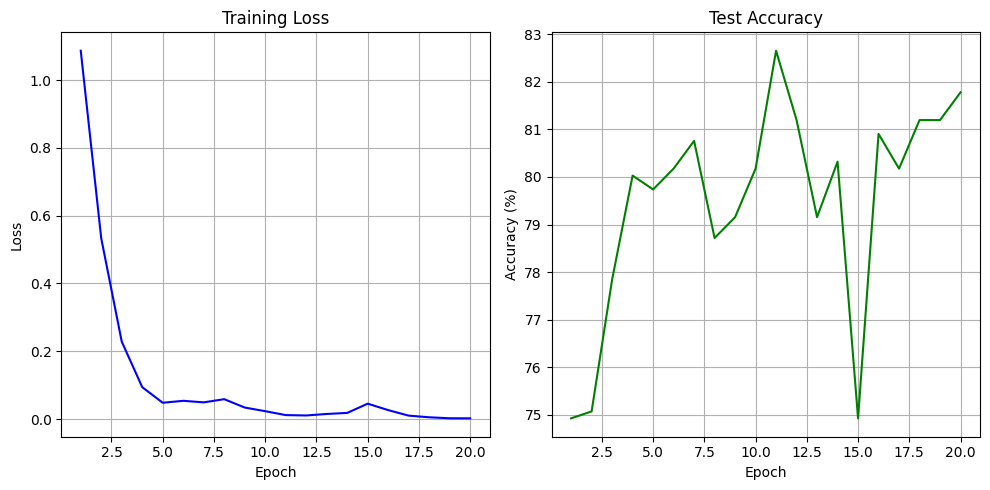

In [24]:
best_lr, best_wd, best_dropout, best_patience = 0.000434,0.000216,0.402,3
model = model_fn_partial(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 20
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
torch.save(best_model_state, "best_model_eff_partial.pth")


In [ ]:
NOTE: test accuracy is a typo its validation acc, im writing it here because we noticed it too late to re run everything

In [15]:
def model_dino_freezeout(dropout=0.4, num_classes=6):
    model = timm.create_model("vit_base_patch16_224_dino", pretrained=True, num_classes=0)

    for param in model.parameters():
        param.requires_grad = False

    model.head = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.num_features, num_classes)
    )

    return model

def model_dino_fulltrain(dropout=0.4, num_classes=6):
    model = timm.create_model("vit_base_patch16_224_dino", pretrained=True, num_classes=0)

    for param in model.parameters():
        param.requires_grad = True

    model.head = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.num_features, num_classes)
    )

    return model

def model_dino_partialtrain(dropout=0.4, num_classes=6, n_blocks=3):
    model = timm.create_model("vit_base_patch16_224_dino", pretrained=True, num_classes=0)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last n_blocks
    for name, param in model.named_parameters():
        if any(f"blocks.{i}" in name for i in range(12 - n_blocks, 12)) or "norm" in name:
            param.requires_grad = True

    model.head = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.num_features, num_classes)
    )

    return model

# Freezeout - Dino

In [55]:
num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate_on_feature_extract(**params,model_function=model_dino_freezeout, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000140, wd=0.000493, dr=0.180, patience=4 ===
Epoch [01/5] | Train Loss: 1.8812 | Train Acc: 0.3103 | Val Acc: 0.4694 | Best: 0.4694 ✅ | LR: 0.000140
Epoch [02/5] | Train Loss: 1.3215 | Train Acc: 0.5202 | Val Acc: 0.5816 | Best: 0.5816 ✅ | LR: 0.000140
Epoch [03/5] | Train Loss: 1.1082 | Train Acc: 0.6030 | Val Acc: 0.6181 | Best: 0.6181 ✅ | LR: 0.000140
Epoch [04/5] | Train Loss: 1.0205 | Train Acc: 0.6363 | Val Acc: 0.6574 | Best: 0.6574 ✅ | LR: 0.000140
Epoch [05/5] | Train Loss: 0.9495 | Train Acc: 0.6622 | Val Acc: 0.6749 | Best: 0.6749 ✅ | LR: 0.000140
[1/10] lr=0.000140, wd=0.000493, dr=0.180, pt=4 -> val acc=0.6749

=== Training with lr=0.000164, wd=0.000014, dr=0.380, patience=2 ===
Epoch [01/5] | Train Loss: 2.0287 | Train Acc: 0.2926 | Val Acc: 0.5379 | Best: 0.5379 ✅ | LR: 0.000164
Epoch [02/5] | Train Loss: 1.4327 | Train Acc: 0.4834 | Val Acc: 0.6239 | Best: 0.6239 ✅ | LR: 0.000164
Epoch [03/5] | Train Loss: 1.2427 | Train Acc: 0.5503 | Val A

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_patch16_224_dino to current vit_base_patch16_224.dino.
  model = create_fn(


Epoch 1/20 | Train Loss: 1.4626 | Validation Accuracy: 69.83%
Epoch 2/20 | Train Loss: 1.0208 | Validation Accuracy: 71.43%
Epoch 3/20 | Train Loss: 0.9168 | Validation Accuracy: 72.89%
Epoch 4/20 | Train Loss: 0.8890 | Validation Accuracy: 72.59%
Epoch 5/20 | Train Loss: 0.8744 | Validation Accuracy: 72.59%
Epoch 6/20 | Train Loss: 0.8373 | Validation Accuracy: 73.18%
Epoch 7/20 | Train Loss: 0.8452 | Validation Accuracy: 73.18%
Epoch 8/20 | Train Loss: 0.8518 | Validation Accuracy: 72.59%
Epoch 9/20 | Train Loss: 0.8523 | Validation Accuracy: 74.34%
Epoch 10/20 | Train Loss: 0.8400 | Validation Accuracy: 73.18%
Epoch 11/20 | Train Loss: 0.8331 | Validation Accuracy: 73.91%
Epoch 12/20 | Train Loss: 0.8557 | Validation Accuracy: 72.01%
Epoch 13/20 | Train Loss: 0.8341 | Validation Accuracy: 70.41%
Epoch 14/20 | Train Loss: 0.8323 | Validation Accuracy: 73.03%
Epoch 15/20 | Train Loss: 0.8022 | Validation Accuracy: 75.07%
Epoch 16/20 | Train Loss: 0.8070 | Validation Accuracy: 75.22%
E

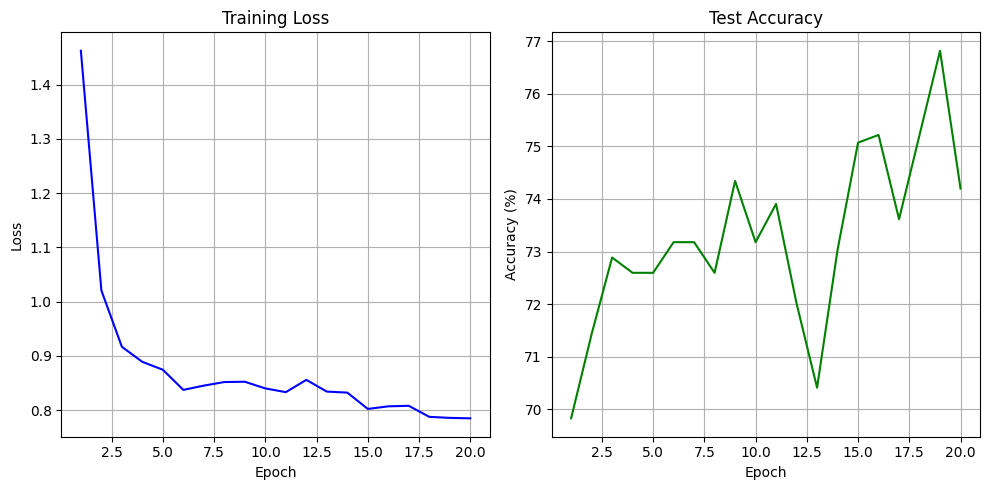

In [25]:
best_lr, best_wd, best_dropout, best_patience = 0.000917,0.000062, 0.468, 4
model = model_dino_freezeout(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 20
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
torch.save(best_model_state, "best_model_dino_freezeout.pth")


In [ ]:
NOTE: test accuracy is a typo its validation acc, im writing it here because we noticed it too late to re run everything

# Full model train - Dino

In [16]:
lr_range = (0.001, 0.0001)
wd_range = (1e-6, 1e-3)
dropout_range = (0.1, 0.6)
patience_range = (2, 4)
num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate_on_feature_extract(**params,model_function=model_dino_fulltrain, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_patch16_224_dino to current vit_base_patch16_224.dino.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



=== Training with lr=0.000551, wd=0.000001, dr=0.332, patience=4 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [01/5] | Train Loss: 2.3887 | Train Acc: 0.2456 | Val Acc: 0.3834 | Best: 0.3834 ✅ | LR: 0.000551
Epoch [02/5] | Train Loss: 1.4899 | Train Acc: 0.4071 | Val Acc: 0.4621 | Best: 0.4621 ✅ | LR: 0.000551
Epoch [03/5] | Train Loss: 1.3675 | Train Acc: 0.4614 | Val Acc: 0.5146 | Best: 0.5146 ✅ | LR: 0.000551
Epoch [04/5] | Train Loss: 1.2876 | Train Acc: 0.4954 | Val Acc: 0.4825 | Best: 0.5146 — | LR: 0.000551
Epoch [05/5] | Train Loss: 1.2130 | Train Acc: 0.5290 | Val Acc: 0.5117 | Best: 0.5146 — | LR: 0.000551
[1/10] lr=0.000551, wd=0.000001, dr=0.332, pt=4 -> val acc=0.5146

=== Training with lr=0.000159, wd=0.000124, dr=0.148, patience=2 ===
Epoch [01/5] | Train Loss: 1.9296 | Train Acc: 0.3376 | Val Acc: 0.4052 | Best: 0.4052 ✅ | LR: 0.000159
Epoch [02/5] | Train Loss: 1.3184 | Train Acc: 0.4892 | Val Acc: 0.5583 | Best: 0.5583 ✅ | LR: 0.000159
Epoch [03/5] | Train Loss: 1.1097 | Train Acc: 0.5940 | Val Acc: 0.6224 | Best: 0.6224 ✅ | LR: 0.000159
Epoch [04/5] | Train Loss: 0.932

Epoch 1/20 | Train Loss: 1.2055 | Validation Accuracy: 76.24%
Epoch 2/20 | Train Loss: 0.5683 | Validation Accuracy: 73.76%
Epoch 3/20 | Train Loss: 0.2668 | Validation Accuracy: 77.55%
Epoch 4/20 | Train Loss: 0.1949 | Validation Accuracy: 78.28%
Epoch 5/20 | Train Loss: 0.1508 | Validation Accuracy: 73.47%
Epoch 6/20 | Train Loss: 0.1086 | Validation Accuracy: 80.47%
Epoch 7/20 | Train Loss: 0.0692 | Validation Accuracy: 79.45%
Epoch 8/20 | Train Loss: 0.0999 | Validation Accuracy: 78.13%
Epoch 9/20 | Train Loss: 0.0886 | Validation Accuracy: 79.30%
Epoch 10/20 | Train Loss: 0.0627 | Validation Accuracy: 80.17%
Epoch 11/20 | Train Loss: 0.0402 | Validation Accuracy: 81.92%
Epoch 12/20 | Train Loss: 0.0451 | Validation Accuracy: 79.01%
Epoch 13/20 | Train Loss: 0.0667 | Validation Accuracy: 78.43%
Epoch 14/20 | Train Loss: 0.0797 | Validation Accuracy: 78.86%
Epoch 15/20 | Train Loss: 0.0534 | Validation Accuracy: 80.76%
Epoch 16/20 | Train Loss: 0.0291 | Validation Accuracy: 82.51%
E

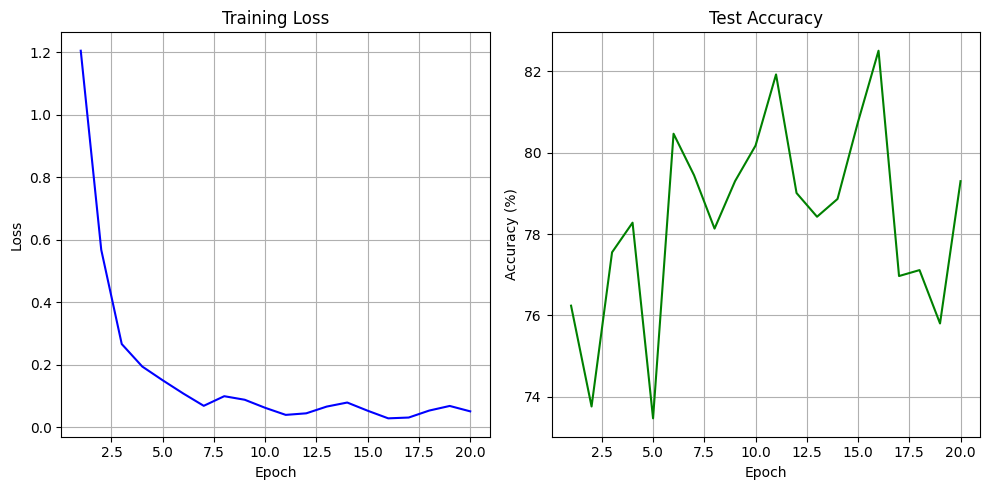

In [26]:
best_lr, best_wd, best_dropout, best_patience = 0.000135,0.000043,0.211,4
model = model_dino_fulltrain(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 20
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
torch.save(best_model_state, "best_model_dino_fulltrain.pth")


In [ ]:
NOTE: test accuracy is a typo its validation acc, im writing it here because we noticed it too late to re run everything

# Partial model train - Dino

In [18]:
lr_range = (0.001, 0.0001)
wd_range = (1e-6, 1e-3)
dropout_range = (0.1, 0.6)
patience_range = (2, 4)
num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate_on_feature_extract(**params,model_function=model_dino_partialtrain, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000979, wd=0.000001, dr=0.569, patience=4 ===
Epoch [01/5] | Train Loss: 1.4197 | Train Acc: 0.6070 | Val Acc: 0.7216 | Best: 0.7216 ✅ | LR: 0.000979
Epoch [02/5] | Train Loss: 0.6226 | Train Acc: 0.7777 | Val Acc: 0.7522 | Best: 0.7522 ✅ | LR: 0.000979
Epoch [03/5] | Train Loss: 0.4242 | Train Acc: 0.8519 | Val Acc: 0.7668 | Best: 0.7668 ✅ | LR: 0.000979
Epoch [04/5] | Train Loss: 0.3450 | Train Acc: 0.8726 | Val Acc: 0.7347 | Best: 0.7668 — | LR: 0.000979
Epoch [05/5] | Train Loss: 0.2744 | Train Acc: 0.9067 | Val Acc: 0.7624 | Best: 0.7668 — | LR: 0.000979
[1/10] lr=0.000979, wd=0.000001, dr=0.569, pt=4 -> val acc=0.7668

=== Training with lr=0.000208, wd=0.000002, dr=0.457, patience=4 ===
Epoch [01/5] | Train Loss: 1.1553 | Train Acc: 0.6368 | Val Acc: 0.7697 | Best: 0.7697 ✅ | LR: 0.000208
Epoch [02/5] | Train Loss: 0.5105 | Train Acc: 0.8263 | Val Acc: 0.8032 | Best: 0.8032 ✅ | LR: 0.000208
Epoch [03/5] | Train Loss: 0.1932 | Train Acc: 0.9306 | Val A

Epoch 1/20 | Train Loss: 1.1158 | Validation Accuracy: 74.78%
Epoch 2/20 | Train Loss: 0.4943 | Validation Accuracy: 78.86%
Epoch 3/20 | Train Loss: 0.1916 | Validation Accuracy: 79.45%
Epoch 4/20 | Train Loss: 0.0717 | Validation Accuracy: 80.61%
Epoch 5/20 | Train Loss: 0.0367 | Validation Accuracy: 80.90%
Epoch 6/20 | Train Loss: 0.0152 | Validation Accuracy: 83.97%
Epoch 7/20 | Train Loss: 0.0111 | Validation Accuracy: 83.53%
Epoch 8/20 | Train Loss: 0.0054 | Validation Accuracy: 83.38%
Epoch 9/20 | Train Loss: 0.0014 | Validation Accuracy: 84.69%
Epoch 10/20 | Train Loss: 0.0004 | Validation Accuracy: 84.26%
Epoch 11/20 | Train Loss: 0.0002 | Validation Accuracy: 84.69%
Epoch 12/20 | Train Loss: 0.0001 | Validation Accuracy: 84.26%
Epoch 13/20 | Train Loss: 0.0001 | Validation Accuracy: 83.97%
Epoch 14/20 | Train Loss: 0.0001 | Validation Accuracy: 83.82%
Epoch 15/20 | Train Loss: 0.0001 | Validation Accuracy: 83.67%
Epoch 16/20 | Train Loss: 0.0001 | Validation Accuracy: 83.82%
E

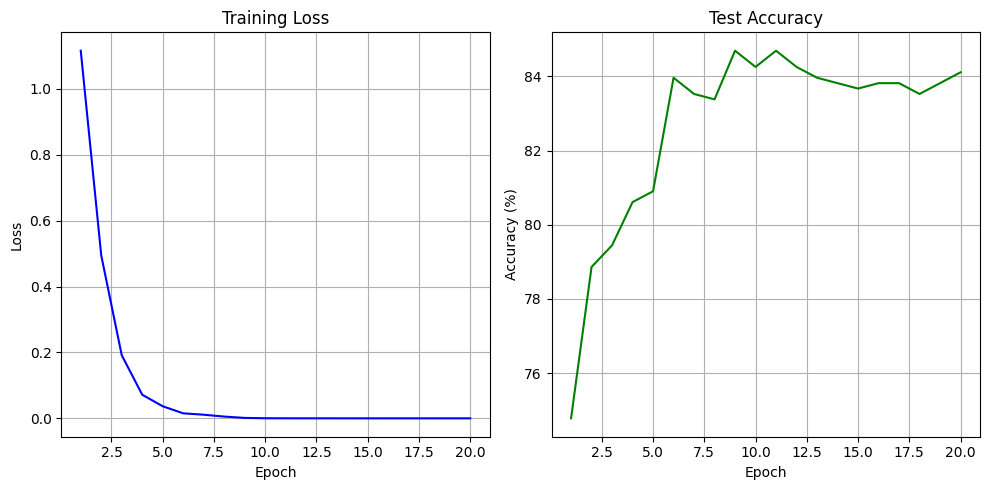

In [19]:
best_lr, best_wd, best_dropout, best_patience = best_params['lr'], best_params['weight_decay'], best_params['dropout'], best_params['patience'] #From earlier because we dont want to run the validaion cell a lot of time

model = model_dino_partialtrain(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 20
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
NOTE: test accuracy is a typo its validation acc, im writing it here because we noticed it too late to re run everything

In [20]:
torch.save(best_model_state, "best_model_dino_partialtrain.pth")

In [30]:
from google.colab import files

files.download("dino_full.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>